In [66]:
import pandas as pd
import re

## Carga de datos

In [ ]:
df = pd.read_pickle("../data/curated/shopify_data.pkl")
df.head()

In [68]:
df.iloc[7890,:].to_dict().keys()

dict_keys(['id_producto', 'titulo_producto', 'descripcion', 'url_tienda', 'tags', 'tipo_producto', 'marca', 'es_llanta', 'es_original', 'precio_producto'])

In [69]:
list(df.tipo_producto.unique())

['SCOOTER',
 'PISTERAS',
 'DOBLE PROPOSITO-OFF ROAD',
 'ENDURO',
 'KIT ARRASTRE',
 'KIT PIÑONES',
 'BANDAS DE FRENO',
 'PASTILLAS DE FRENO',
 'MORDAZA',
 'MANUBRIO',
 'CAUCHO DE MANUBRIO',
 nan,
 'MANIGUETA CLUTCH',
 'PROTECTOR DE MOFLE',
 'CARENAJE',
 'POSAPIE',
 'SOPORTES',
 'SILENCIADOR',
 'Defensa',
 'CARBURADOR',
 'BATERIA',
 'COMANDO',
 'SWITCH ENCENDIDO',
 'DIRECCIONAL',
 'STOP',
 'SISTEMA ELECTRICO',
 'VELOCÍMETRO',
 'FAROLA',
 'MOTOR ARRANQUE',
 'CILINDRO',
 'CIGÜEÑAL',
 'KIT PISTON',
 'RODAMIENTO',
 'CANASTILLA PARA MOTO',
 'AMORTIGUADORES',
 'GUARDABARRO',
 'GUARDAPIERNAS',
 'TAPA PARA MOTO',
 'CUBIERTA VELOCÍMETRO',
 'Tapas',
 'COLA GUARDABARRO',
 'VISOR CARENAJE',
 'TAPA VELOCIMETRO',
 'CAJA FILTRO DE AIRE',
 'GUARDAPOLVO',
 'FILTRO DE AIRE',
 'FILTRO DE ACEITE',
 'Correa/Polea',
 'CORREA DE BATERIA',
 'CORREA DE TRANSMISION',
 'ESPEJO RETROVISOR',
 'SPROCKET',
 'SPROKET',
 'ACEITE DE MOTOR',
 'ACEITE DE SUSPENSION',
 'LEVA CLUTCH',
 'PISTON',
 'PIÑON DE ARRASTRE',
 'KIT S

## Determinar los metadatos relevantes para un producto

**Identificación y básicos**
- 'id_producto'
- 'titulo_producto'
- 'descripcion' 
- 'url_tienda'
- 'marca'
- 'es_original'
- 'es_llanta'

**Metadatos semánticos y de categorización**
- 'categoria_general' (*nueva*): clasificación amplia del producto, p.ej.: **LLANTA**, **CARROCERIA**, **ACCESORIO**, **REPUESTO MECANICO**, **OTROS**
- 'subtipo_producto' (*nuevo*, complementa **tipo_producto**):
- 'descripcion_categoria'

**Metadatos inferidos del título/tags**
- modelo_moto (*nuevo*):
    - Extraer modelo(s) del **título/tags** si aplica (CB1, Agility 125 RS, Eco Deluxe Hero, etc.).
    - Vacío/None si no hay modelo relevante (llantas universales, genéricas).
    - dimensiones_llanta (solo si es llanta):
        - Ancho, perfil, rin (e.g. 130/70 R17). Útil para filtros de llantas.
        - Puede inferirse de título/tags (ej. ANCHO_130, ALTO_70, RIN_17).

## Metadatos de categorización

**categoria_general**, **subtipo_producto** y **descripcion_categoria**

¿Que categorias considerar?

In [70]:
def muestra_aleatoria(df: pd.DataFrame, n: int, seed: int = None):
    """
    Retorna una lista de diccionarios con n registros aleatorios del DataFrame.
    """
    sample_df = df.sample(n=n, random_state=seed)
    return sample_df.to_dict(orient='records')

In [ ]:
muestra_aleatoria(df, 50)

In [72]:
df['tipo_producto'].value_counts().head(50)

tipo_producto
REPUESTOS PARA MOTO         1994
TAPA PARA MOTO               805
SOPORTES                     724
REPUESTO                     703
TORNILLO                     651
DIRECCIONAL                  527
BUJE PARA MOTO               516
KIT PISTON                   511
RESORTES DE MOTO             509
Repuestos                    443
CARENAJE                     414
RETEN PARA MOTO              369
GUARDABARRO                  336
CABLE ACELERADOR             327
KIT ARRASTRE                 308
ESPEJO RETROVISOR            302
ARANDELA                     299
PIÑON CAJA DE CAMBIOS        297
ANILLOS PISTON               279
FILTRO DE AIRE               276
TUERCA                       253
COMANDO                      248
EMPAQUE GENERAL              243
POSAPIE                      237
ORING de MOTO                224
RODAMIENTO                   222
PIM PARA MOTO                221
FAROLA                       221
PASTILLAS DE FRENO           220
CAUCHO DE MOTO               

### Categorias y Subcategorias

- **LLANTA**
- **FRENOS** (pastillas, bandas, discos, bomba, varillas, portabandas, etc.)
- **TRANSMISIÓN PRIMARIA / CAJA** (piñón primario, selector/árbol/caja de cambios, bendix, eje crank/primario, piñón impulsor…)
- **TRANSMISION SECUNDARIA** (kit arrastre, piñones/sprocket/cadena, guardacadena, tensores)
- **EMBRAGUE / CLUTCH** (discos, separadores, campana, clutch primario/trasero, centrífugo)
- **MOTOR INTERNO** (cilindro, pistón, anillos, biela, cigüeñal, árbol de levas, válvulas, balancines, distribución)
- **ALIMENTACIÓN** (Carburación/Inyección) (carburador y kit, agujas, flotador, TPS, inyectores, filtro gasolina)
- **ELECTRICO / ENCENDIDO** (batería, CDI, bobinas, regulador, bujía, motor arranque, relé)
- **ILUMINACION / SEÑALIZACION** (farola, bombillo, direccional, stop, tapa stop, socket)
- **INSTRUMENTACION / TRANSMISION DE VELOCIDAD** (velocímetro, tacómetro, caja piñón velocímetro, vidrio velocímetro)
- **ESCAPE** (mofle, protector, empaques)
- **SUSPENSION / DIRECCION** (amortiguador, barras, botellas, reten telescopio, cuna dirección, eje tijera)
- **CARROCERIA / PLASTICOS** (guardabarro, tapas/carenajes/visores/aletines, posapiés, aleta tanque)
- **CONTROLES / MANDOS** (manubrio, maniguetas, comandos, cables acelerador/freno/clutch/choke, pedales)
- **FLUIDOS / FILTRACION / LUBRICACION** (aceites motor/suspensión/transmisión, grasa, lubricante cadena, filtros aire/aceite/centrífugo)
- **SUJECION / SELLOS / UNIVERSALES** (tornillos, tuercas, arandelas, o-rings, retenes, empaques, esparragos)
- **REFRIGERACION** (bomba agua, eje bomba agua, ventilador, termostato) 
- **SOPORTE / ESTACIONAMIENTO** (gato central, gato lateral, agarraderas)
- **ACCESORIOS / ELECTRÓNICA AUXILIAR** (radio, cable de seguridad, etc.)
- **OTROS**: fallback si nada calza

In [73]:
import pandas as pd, re, unicodedata

# -------------------------
# Normalización con más fixes
# -------------------------
def norm_txt(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip().upper()
    s = unicodedata.normalize("NFD", s)
    s = re.sub(r"[\u0300-\u036F]", "", s)  # quita tildes

    rep = {
        "SPROKET": "SPROCKET",
        "BOMBILLOS": "BOMBILLO",
        "CAUCHO DE POSPIES": "CAUCHO DE POSAPIES",
        "CAMPANA CLUCTH": "CAMPANA CLUTCH",
        "CLUCTH": "CLUTCH",
        "BOMBA DE ACIETE": "BOMBA ACEITE",
        "SWICTH": "SWITCH",
        "DIRECCIONALSTOP": "DIRECCIONAL STOP",
        "MANILAR": "MANUBRIO",
        "NEUMATICO": "LLANTA",
        "ESPARRRAGO": "ESPARRAGO",
        "CORREA/POLÉA": "CORREA/POLEA",
        "CIGUENAL": "CIGUEÑAL",
        "SENDOR": "SENSOR",
        "PIM PARA MOTO": "PIN PARA MOTO",
        "PINON": "PIÑON",  # unifica
        "EMPAQIUE": "EMPAQUE"  # <-- corregimos el typo
    }
    for a, b in rep.items():
        s = s.replace(a, b)
    return s

def is_llanta_row(row) -> bool:
    if "es_llanta" in row and pd.notna(row["es_llanta"]):
        return bool(row["es_llanta"])
    t = norm_txt(row.get("tipo_producto", ""))
    return any(k in t for k in ["LLANTA","SCOOTER","PISTERAS","DOBLE PROPOSITO","ENDURO"])

def _text_blob(row) -> str:
    # Fallback cuando tipo_producto está vacío: usa título + tags
    parts = [
        row.get("tipo_producto", ""),
        row.get("titulo_producto", ""),
        row.get("tags", ""),
    ]
    return norm_txt(" ".join([p for p in parts if isinstance(p, str)]))

# -------------------------
# Reglas regex por categoría
# -------------------------
RULES = [
    # FRENOS
    ("FRENOS",
     r"\b(FRENO|PASTILLA(S)?|BANDA(S)?|DISCO DE FRENO|BOMBA FRENO|LEVA FRENO|VARILLA FRENO|PORTABANDAS|PEDAL DE FRENOS|EJE ABREBANDAS|VARILLA PORTA BANDAS|MORDAZA)\b"),

    # TRANSMISION SECUNDARIA
    ("TRANSMISION SECUNDARIA",
     r"\b(ARRASTRE|SPROCKET|CADENA TRANSMISION|GUARDACADENA|TENSOR CADENA|PORTA SPROCKET|CAUCHO PORTA SPROCKET|DESLIZADOR CADENA|PIÑON DE TRANSMISION|PIÑON DE LA CORONA|KIT (ARRASTRE|PIÑONES|SPROCKET)|CORREA DE TRANSMISION)\b"),

    # EMBRAGUE / CLUTCH
    ("EMBRAGUE / CLUTCH",
     r"\b(CLUTCH|DISCO (SEPARADOR )?CLUTCH|SEPARADOR CLUTCH|CAMPANA CLUTCH|CAMPANA\b|CLUTCH (PRIMARIO|TRASERO|AUTOMATICO)|CLUTCH DE ARRANQUE|DISCO SEPARADOR(?!.*FRENO))\b"),

    # MOTOR INTERNO
    ("MOTOR INTERNO",
     r"\b(CILINDRO|PISTON|ANILLOS|BIELA|CIGUEÑAL|ARBOL DE LEVAS|VALVULA(S)?|BALANCIN|DISTRIBUCION|CADENILLA|TENSOR CADENILLA|EJE CRANK|PIÑON (CIG|CRANK)|PIÑON DE (DISTRIBUCCION|DISTRIBUCION|SINCRONIZACION)|PIÑON (CONTRABALANCEADOR|DE BALANCEADOR)|EJE (BALANCEADOR|DE MOTOR)|BOMBA ACEITE|PIÑON BOMBA DE ACEITE|VARILLA DE EMPUJE|MIRILLA DE ACEITE|MOTOR)\b"),

    # TRANSMISION PRIMARIA / CAJA
    ("TRANSMISION PRIMARIA / CAJA",
    r"\b(PIÑON (PRIMARIO|CAJA DE CAMBIOS|SELECTOR DE CAMBIOS|IMPULSOR DE ARRANQUE|NEUTRO|LOCO|DE ARRANQUE|DE ENGRANAJE|DE ARRANQUE|SALIDA)|"
    r"SELECTOR DE CAMBIOS|"
    r"EJE (PRIMARIO|DE CAMBIOS|SELECTOR CAMBIOS|DE SALIDA|PEDAL CAMBIO|DE BAJA|TRACCION|PIÑON ARRANQUE|DESCOMPRESOR)|"
    r"LEVA DE CAMBIOS|ROLLERS|CORREA/POLEA|LEVA POLEA|BENDIX|PIÑON MOTOR DE ARRANQUE)\b"),

    # ALIMENTACION (carburación/inyección/combustible)
    ("ALIMENTACION",
     r"\b(CARBURADOR|KIT CARBURADOR|AGUJA( (AIRE|CORTINA|FLOTADOR))?|FLOTADOR|BOQUEREL|VALVULA.*AIRE|"
     r"FILTRO (DE )?(GASOLINA|LLAVE DE GASOLINA|VALVULA DE AIRE|GASES|ROTATORIO)|FILTROS|"
     r"TANQUE DE GASOLINA|BOMBA GASOLINA|CUERPO DE INYECCION|SENSOR( DEL| DE)? (GASOLINA))\b"),

    # ELECTRICO / ENCENDIDO
    ("ELECTRICO / ENCENDIDO",
     r"\b(BATERIA|BOBINA|CDI|REGULADOR|BUJIA|MOTOR ARRANQUE|RELAY ARRANQUE|VOLANTE MAGNETICO|ESCOBILLAS|"
     r"SENSOR( DEL| DE)? (TPS|VELOCIDAD|OXIGENO|TEMPERATURA|ACELERADOR|INCLINACION)|SOCKET|CAPUCHON BUJIA|PLATO DE BOBINAS|"
     r"SWITCH (NEUTRO|PRESION DE ACEITE))\b"),

    # ILUMINACION / SEÑALIZACION
    ("ILUMINACION / SEÑALIZACION",
     r"\b(FAROLA|BOMBILLO(S)?|DIRECCIONAL(ES)?|STOP|TAPA STOP|VIDRIO VELOCIMETRO|ARO FAROLA|CLAXON|PITO)\b"),

    # ESPEJOS
    ("ESPEJOS",
     r"\b(ESPEJO RETROVISOR|ESPEJO)\b"),

    # INSTRUMENTACION
    ("INSTRUMENTACION",
     r"\b(VELOCIMETRO|TACOMETRO|CAJA PIÑON VELOCIMETRO|CUBIERTA VELOCIMETRO)\b"),

    # ESCAPE
    ("ESCAPE",
     r"\b(MOFLE|PROTECTOR DE MOFLE|EMPAQUE MOFLE|SILENCIADOR)\b"),

    # SUSPENSION / DIRECCION
    ("SUSPENSION / DIRECCION",
     r"\b(AMORTIGUADOR(ES)?|BARRA(S)? DE SUSPENSION|BOTELLAS DE SUSPENSION|RETEN TELESCOPIO|CUNAS DE DIRECCION|"
     r"KIT CUNAS DE DIRECCION|EJE TIJERA|TIJERA|VARILLA TORQUE|RESORTES DE MOTO|GUARDAPOLVO)\b"),

    # CARROCERIA / PLASTICOS
    ("CARROCERIA / PLASTICOS",
     r"\b(GUARDABARRO(S)?|CARENAJE|TAPA(S)?|COLA GUARDABARRO|VISOR|ALETA(S)?(.*TANQUE)?|CARCASA|GUARDAPIERNAS|"
     r"CANASTILLA|POSAPIE|CAUCHO (DE )?POSAPIES|CAUCHO SILLIN|AGARRADERA|DEFENSA|PROTECTOR DE MOTO|CAUCHO DE MOTO)\b"),

    # SOPORTES / BRACKETS
    ("SOPORTES / BRACKETS",
     r"\b(SOPORTES?|SOPORTE)\b"),

    # CONTROLES / MANDOS
    ("CONTROLES / MANDOS",
     r"\b(MANUBRIO|MANIGUETA(S)?|COMANDO|CABLE (ACELERADOR|FRENO|CLUTCH|CHOKE|CARBURADOR|BOMBA ACEITE|RPM|SILLIN|YPVS|DESCOMPRESOR|CONTROLADOR RPM)|"
     r"PEDAL( DE)? CAMBIOS|PEDAL CRANK|"
     r"LEVA (CLUTCH|PEDAL|CHOKE|DESCOMPRESOR|SELECTOR DE CAMBIOS|DE CAMBIOS)|"
     r"CAJA DE ACELERADOR|CARRETEL (DE )?ACELERADOR|"
     r"BOTON INTERRUPTOR( (DE )?(APAGADO Y ARRANQUE|DIRECCIONALES|ESTACIONARIAS|ENCENDIDO|CAMBIO DE LUCES))?|"
     r"SWITCH( ENCENDIDO)?|ACELERADOR DE CUARTA)\b"),

    # FLUIDOS / FILTRACION / LUBRICACION
    ("FLUIDOS / FILTRACION / LUBRICACION",
     r"\b(ACEITE( DE (MOTOR|SUSPENSION|TRANSMISION))?|GRASA|LUBRICANTE( DE CADENA)?|"
     r"FILTRO (DE )?(AIRE|ACEITE|CENTRIFUGO|GASES|ROTATORIO)|FILTROS|DESENGRASANTE DE CADENA|MIRILLA DE ACEITE|BOMBA ACEITE)\b"),

    # SUJECION / SELLOS / UNIVERSALES
    ("SUJECION / SELLOS / UNIVERSALES",
    r"\b(TORNILLO|TUERCA|ARANDELA|O(-)?RING|ORING|RETEN(ES)?|EMPAQUE(S)?|ESPARRAGO|PASADOR(ES)?|"
    r"BALINERA|ANTIVIBRANTE|TAPON DE MOTO|RODAMIENTO|ABRAZADERA|PIN PARA MOTO|BUJE|DISCO AJUSTE)\b"),

    # REFRIGERACION
    ("REFRIGERACION",
     r"\b(BOMBA AGUA|EJE BOMBA DE AGUA|PIÑON BOMBA DE AGUA|TERMOSTATO|VENTILADOR)\b"),

    # SOPORTE / ESTACIONAMIENTO
    ("SOPORTE / ESTACIONAMIENTO",
     r"\b(GATO CENTRAL|GATO LATERAL)\b"),

    # RINES / ACCESORIOS LLANTA
    ("RINES / ACCESORIOS LLANTA",
     r"\b(RIN DE MOTO|VALVULA DE LLANTA|EJE LLANTA|SET(S)? DE RADIOS)\b"),

    # ACCESORIOS / ELECTRONICA AUXILIAR
    ("ACCESORIOS / ELECTRONICA AUXILIAR",
     r"\b(RADIO PARA MOTO|CABLE DE SEGURIDAD)\b"),
]

LLANTA_SUBTIPOS = {"SCOOTER","PISTERAS", "DOBLE PROPOSITO-OFF ROAD","ENDURO","LLANTA"}

def categorizar(row) -> tuple[str, str]:
    # Texto principal
    t = norm_txt(row.get("tipo_producto", ""))
    # Llantas
    if is_llanta_row(row):
        subtipo = t if t in LLANTA_SUBTIPOS and t != "" else "LLANTA"
        return ("LLANTA", subtipo)
    # Reglas sobre tipo
    for categoria, pat in RULES:
        if re.search(pat, t):
            return (categoria, t if t else categoria)
    # Fallback: si no hay tipo, intentar con título+tags
    if t == "":
        blob = _text_blob(row)
        for categoria, pat in RULES:
            if re.search(pat, blob):
                return (categoria, t if t else categoria)
    # Fallbacks genéricos
    if t in {"FRENOS"}:
        return ("FRENOS", t)
    if t in {"REPUESTO","REPUESTOS","REPUESTOS PARA MOTO","ELECTRICO","SISTEMA ELECTRICO"}:
        return ("ELECTRICO / ENCENDIDO", t)
    return ("OTROS", t)

# -------------------------
# Aplicar al DataFrame
# -------------------------
df = df.copy()
df['tipo_producto'] = df['tipo_producto'].replace({'PISTERA': 'PISTERAS'})
df["tipo_norm"] = df["tipo_producto"].apply(norm_txt)

cats = df.apply(lambda r: pd.Series(categorizar(r), index=["categoria_general","subtipo_producto"]), axis=1)
df[["categoria_general","subtipo_producto"]] = cats

coverage = (df["categoria_general"] != "OTROS").mean()
print(f"Cobertura de reglas: {coverage:.1%}")

pendientes = (df.loc[df["categoria_general"]=="OTROS","subtipo_producto"]
                .value_counts()
                .head(50))
print("\nPendientes más frecuentes en OTROS:")
print(pendientes)

Cobertura de reglas: 96.6%

Pendientes más frecuentes en OTROS:
subtipo_producto
    915
Name: count, dtype: int64


In [ ]:
df[df.tipo_producto == 'CABLE ACELERADOR'].iloc[10,:].to_dict()

In [ ]:
df[df.tipo_producto == 'CABLE ACELERADOR'].iloc[100,:].to_dict()

In [76]:
df.categoria_general.value_counts()

categoria_general
ELECTRICO / ENCENDIDO                 4226
SUJECION / SELLOS / UNIVERSALES       3625
CARROCERIA / PLASTICOS                2811
MOTOR INTERNO                         2806
CONTROLES / MANDOS                    1544
FRENOS                                1374
SUSPENSION / DIRECCION                1247
ILUMINACION / SEÑALIZACION            1214
EMBRAGUE / CLUTCH                     1207
TRANSMISION SECUNDARIA                1098
OTROS                                  915
ALIMENTACION                           783
SOPORTES / BRACKETS                    743
TRANSMISION PRIMARIA / CAJA            701
INSTRUMENTACION                        472
LLANTA                                 445
FLUIDOS / FILTRACION / LUBRICACION     389
ESPEJOS                                304
RINES / ACCESORIOS LLANTA              266
ESCAPE                                 252
SOPORTE / ESTACIONAMIENTO              170
REFRIGERACION                           33
ACCESORIOS / ELECTRONICA AUXILIAR   

In [77]:
df.categoria_general.value_counts()

categoria_general
ELECTRICO / ENCENDIDO                 4226
SUJECION / SELLOS / UNIVERSALES       3625
CARROCERIA / PLASTICOS                2811
MOTOR INTERNO                         2806
CONTROLES / MANDOS                    1544
FRENOS                                1374
SUSPENSION / DIRECCION                1247
ILUMINACION / SEÑALIZACION            1214
EMBRAGUE / CLUTCH                     1207
TRANSMISION SECUNDARIA                1098
OTROS                                  915
ALIMENTACION                           783
SOPORTES / BRACKETS                    743
TRANSMISION PRIMARIA / CAJA            701
INSTRUMENTACION                        472
LLANTA                                 445
FLUIDOS / FILTRACION / LUBRICACION     389
ESPEJOS                                304
RINES / ACCESORIOS LLANTA              266
ESCAPE                                 252
SOPORTE / ESTACIONAMIENTO              170
REFRIGERACION                           33
ACCESORIOS / ELECTRONICA AUXILIAR   

## Analisis de categorias / marcas

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== utilidades ==========
def _add_value_labels(ax, values, fmt="{:.1f}%"):
    """Pinta porcentajes encima de cada barra (si caben)."""
    for rect, val in zip(ax.patches, values):
        height = rect.get_height()
        if height <= 0: 
            continue
        ax.annotate(fmt.format(val),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

def _order_index_by_count(s):
    """Ordena índices por conteo descendente y alfabetiza empates."""
    return s.sort_values(ascending=False).sort_index(kind="stable", level=None)

# ========== 1) Barras por categoria_general (conteo + %) ==========
def plot_categoria_counts_pct(df, col_cat="categoria_general", min_count=1, rotate=45):
    counts = df[col_cat].fillna("NaN").value_counts()
    counts = counts[counts >= min_count]
    total = counts.sum()
    pct = counts / total * 100

    # Orden (desc por conteo)
    counts = counts.sort_values(ascending=False)
    pct = pct.loc[counts.index]

    fig, ax = plt.subplots(figsize=(10, 5))
    counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Distribución por {col_cat} (n={int(total)})")
    ax.set_xlabel(col_cat)
    ax.set_ylabel("Conteo")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, ha="right")

    # Porcentajes como etiquetas
    _add_value_labels(ax, pct.values, fmt="{:.1f}%")
    plt.tight_layout()
    plt.show()

# ========== 2) Barras por marca (conteo + %) ==========
def plot_marca_counts_pct(df, col_brand="marca", top_n=50, rotate=45):
    counts_all = df[col_brand].fillna("NaN").value_counts()
    total = counts_all.sum()
    counts = counts_all.head(top_n)
    pct = counts / total * 100

    fig, ax = plt.subplots(figsize=(10, 5))
    counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Top {top_n} marcas (n={int(total)})")
    ax.set_xlabel("Marca")
    ax.set_ylabel("Conteo")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, ha="right")

    _add_value_labels(ax, pct.values, fmt="{:.1f}%")
    plt.tight_layout()
    plt.show()

# ========== 3) Barras apiladas por categoria_general x marca ==========
def plot_stacked_categoria_by_marca(df, col_cat="categoria_general", col_brand="marca",
                                    top_brands=10, min_count_cat=1, rotate=45, show_legend=True):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Filtrar categorías con suficientes registros
    valid_cats = df[col_cat].fillna("NaN")
    cat_counts = valid_cats.value_counts()
    cats = cat_counts[cat_counts >= min_count_cat].index.tolist()

    # Elegir Top-N marcas (globales)
    top_brand_list = (df[col_brand].fillna("NaN")
                        .value_counts()
                        .head(top_brands)
                        .index.tolist())

    # Reetiquetar marcas fuera del top como "OTRAS"
    brand_series = df[col_brand].fillna("NaN").where(df[col_brand].isin(top_brand_list), "OTRAS")

    # Tabla de contingencia
    pivot = (pd.crosstab(df[col_cat].fillna("NaN"), brand_series)
               .loc[cats])

    # Ordenar categorías por total desc para legibilidad
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(14, 7))  # ancho mayor para más etiquetas
    pivot.plot(kind="bar", stacked=True, ax=ax)

    ax.set_title(f"{col_cat} apilado por marca (Top {top_brands} + OTRAS)")
    ax.set_xlabel(col_cat)
    ax.set_ylabel("Conteo")

    # --- Ajuste de etiquetas eje X ---
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar 45° y alinear a la derecha
    plt.subplots_adjust(bottom=0.3)  # Deja espacio extra para etiquetas

    if show_legend:
        ax.legend(title="Marca", bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend_.remove()

    plt.tight_layout()
    plt.show()

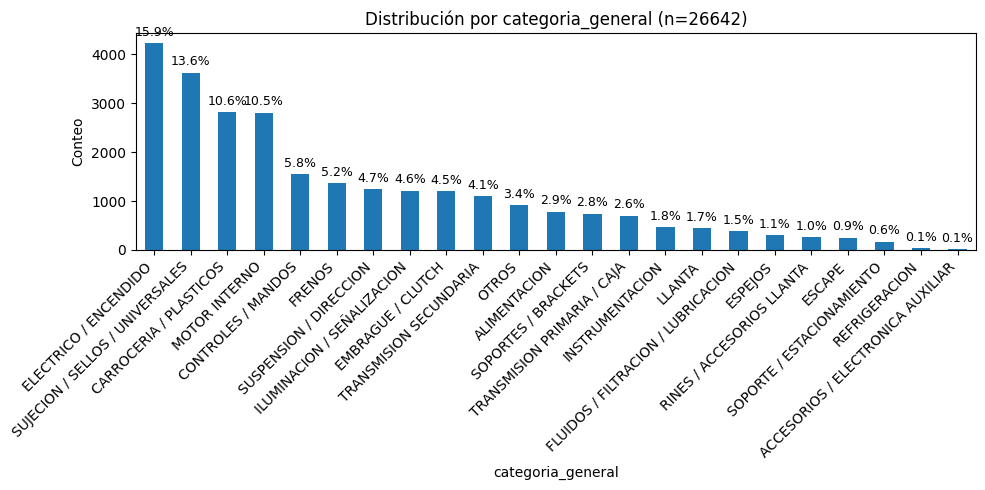

In [79]:
# ========== Ejemplos de uso ==========
# 1) Conteo + % por categoría
plot_categoria_counts_pct(df, col_cat="categoria_general", min_count=1, rotate=45)

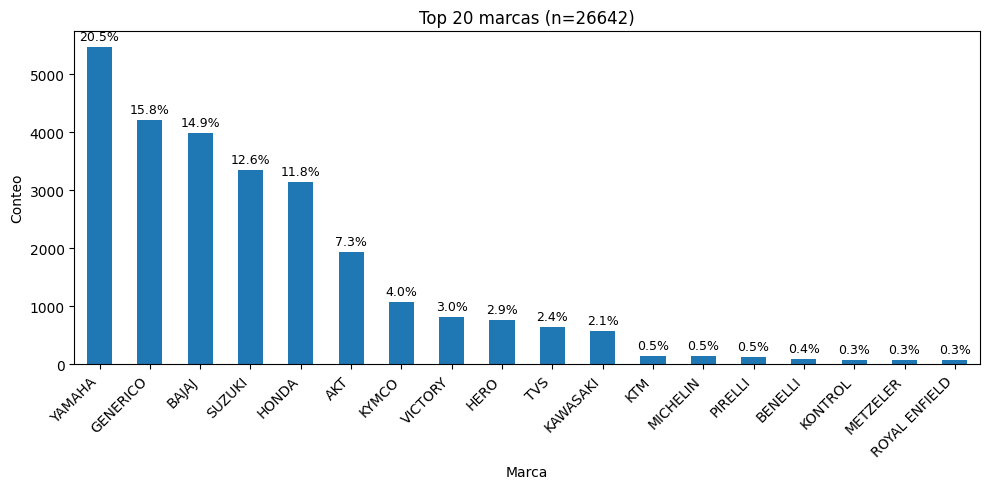

In [80]:
# 2) Conteo + % por marca (Top 20)
plot_marca_counts_pct(df, col_brand="marca", top_n=20, rotate=45)

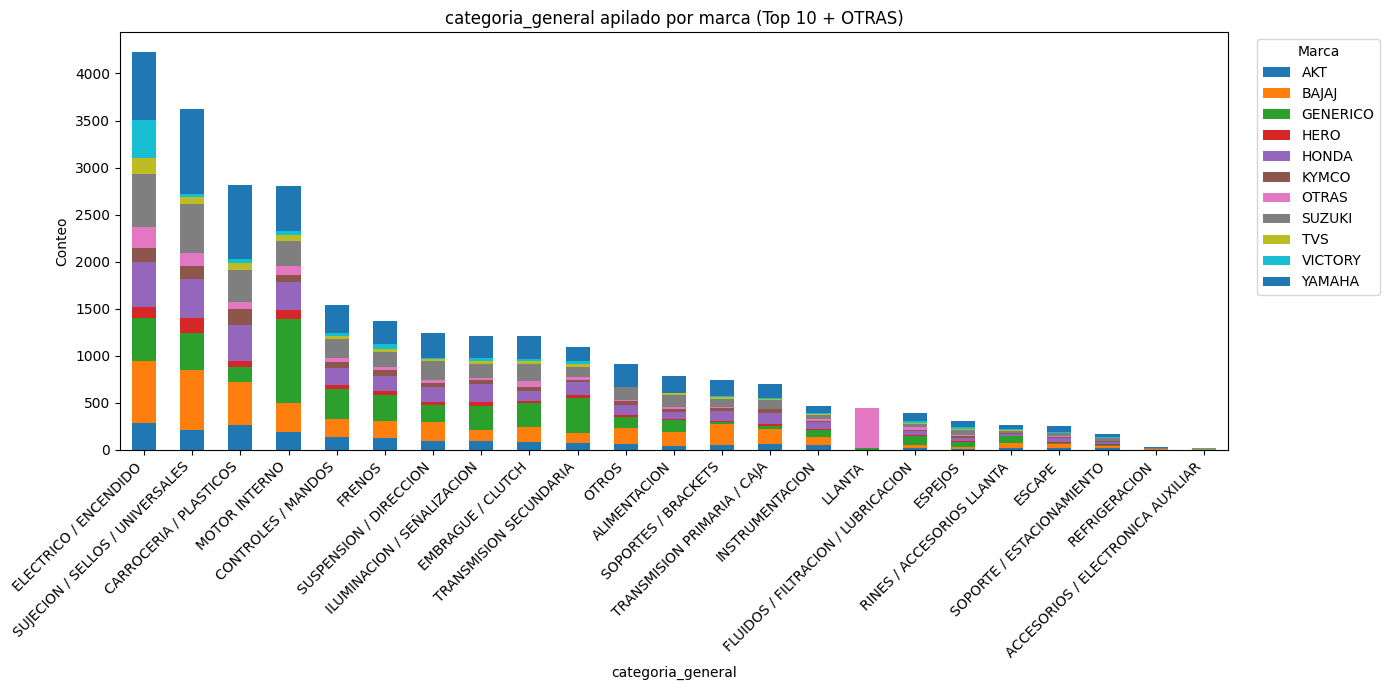

In [81]:
# 3) Apilado: categorías x marca (Top 10 marcas + OTRAS)
plot_stacked_categoria_by_marca(df, col_cat="categoria_general", col_brand="marca",
                                top_brands=10, min_count_cat=1, rotate=0, show_legend=True)

In [ ]:
# Requisitos (ejecútalo una vez por notebook)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display

# --- Helper para poner etiquetas de % sobre cada barra (opcional) ---
def _add_pct_labels(ax, counts):
    total = counts.sum()
    if total == 0:
        return
    for rect, val in zip(ax.patches, counts.values):
        if val <= 0:
            continue
        pct = 100.0 * val / total
        ax.annotate(f"{pct:.1f}%",
                    (rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

# --- Función de dibujo ---
def plot_subtipos_by_categoria(df, categoria, top_n=20, min_count=1, show_pct=False, rotate=45):
    # Filtra categoría
    dff = df[df["categoria_general"].fillna("NaN") == categoria].copy()

    # Conteos por subtipo (rellenar NaN y limpiar string vacío)
    sub = (dff["subtipo_producto"]
           .fillna("NaN")
           .replace("", "NaN")
           .astype(str))
    counts = sub.value_counts()

    # Aplica min_count y top_n
    counts = counts[counts >= min_count].head(top_n)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    counts.plot(kind="bar", ax=ax)

    ax.set_title(f"Subtipos en '{categoria}' · Top {len(counts)} (n={int(sub.size)})")
    ax.set_xlabel("Subtipo de producto")
    ax.set_ylabel("Conteo")

    # Rotación etiquetas eje X
    plt.setp(ax.get_xticklabels(), rotation=rotate, ha="right")
    plt.subplots_adjust(bottom=0.25)

    # Etiquetas de % (opcional)
    if show_pct:
        _add_pct_labels(ax, counts)

    plt.tight_layout()
    plt.show()

# --- Widgets ---
categorias = sorted(df["categoria_general"].fillna("NaN").unique().tolist())

dd_cat   = w.Dropdown(options=categorias, value=categorias[0], description="Categoría:")
sl_top   = w.IntSlider(value=20, min=5, max=50, step=1, description="Top N:")
sl_min   = w.IntSlider(value=1, min=1, max=20, step=1, description="min_count:")
cb_pct   = w.Checkbox(value=False, description="Mostrar % sobre barras")
sl_rot   = w.IntSlider(value=45, min=0, max=90, step=5, description="Rotaciónº")

ui = w.HBox([dd_cat, sl_top, sl_min, cb_pct, sl_rot])
out = w.Output()

def _update(*args):
    with out:
        out.clear_output(wait=True)
        plot_subtipos_by_categoria(
            df=df,
            categoria=dd_cat.value,
            top_n=sl_top.value,
            min_count=sl_min.value,
            show_pct=cb_pct.value,
            rotate=sl_rot.value
        )

# enlazar cambios
for wid in (dd_cat, sl_top, sl_min, cb_pct, sl_rot):
    wid.observe(_update, names="value")

# mostrar
display(ui, out)
_update()  # primer render


Output()

In [93]:
df.to_pickle("../data/curated/shopify_data_cat_gen.pkl")

In [57]:
df[df.es_llanta].subtipo_producto.unique()

array(['SCOOTER', 'PISTERAS', 'DOBLE PROPOSITO-OFF ROAD', 'ENDURO',
       'LLANTA'], dtype=object)

In [ ]:
# Conteo por vendor (incluyendo NaN como categoría) (SOLO LLANTAS)
df_llantas = df[df.es_llanta]
df_llantas.head(2)

## obtener modelo 

In [89]:
import re
import pandas as pd
from collections import Counter

# --- 1) Tokenizar preservando "(...)" como un solo token ---
TOKEN_RE = re.compile(
    r"\([^)]*\)"                      # 1) cualquier bloque entre paréntesis, como "(Negro - 1 Unidad)"
    r"|[A-Za-zÁÉÍÓÚÜÑ0-9]+"           # 2) palabras y números
    r"(?:[-/][A-Za-zÁÉÍÓÚÜÑ0-9]+)*",  #    seguidas opcionalmente por - o / + más alfanum.
    flags=re.IGNORECASE
)

def tokenize_preserving_parens(text: str):
    if not isinstance(text, str):
        text = "" if text is None else str(text)
    # normaliza espacios, pero no quita paréntesis
    tokens = TOKEN_RE.findall(text)
    # opcional: normaliza a MAYÚSCULAS para agrupar mejor
    tokens = [t.upper().strip() for t in tokens if t.strip()]
    return tokens

# --- 2) Bigrams consecutivos ---
def bigrams(seq):
    return list(zip(seq, seq[1:]))

# --- 3) Top bigrams por marca ---
def top_bigrams_by_brand(df, brand_col="marca", title_col="titulo_producto",
                         marca="YAMAHA", top_n=30):
    dff = df[df[brand_col] == marca]
    counter = Counter()
    total_titles = 0

    for title in dff[title_col].dropna():
        toks = tokenize_preserving_parens(title)
        if len(toks) >= 2:
            counter.update(bigrams(toks))
            total_titles += 1

    # a DataFrame bonito
    pairs, freqs = zip(*counter.most_common(top_n)) if counter else ([], [])
    out = pd.DataFrame({
        "bigram": [' '.join(p) for p in pairs],
        "freq": freqs
    })
    if len(counter) > 0:
        out["pct_sobre_bigrams"] = out["freq"] / sum(counter.values()) * 100
    return out

# --- Uso ---
# df: tu DataFrame con columnas 'marca' y 'titulo_producto'
top_bi = top_bigrams_by_brand(df, marca="YAMAHA", top_n=40)
display(top_bi)

,bigram,freq,pct_sobre_bigrams
0,YAMAHA ORIGINAL,4172,12.928416
1,125 YAMAHA,545,1.688875
2,150 YAMAHA,387,1.199256
3,FZ16 150,351,1.087698
4,BWS 125,331,1.025720
5,110 YAMAHA,319,0.988534
6,115 YAMAHA,292,0.904865
7,250 YAMAHA,234,0.725132
8,CRYPTON 115,223,0.691044
9,LIBERO 125,221,0.684847


## Posibles Modelos por Marca

In [90]:
marcas = [
    'AKT', 
    'GENERICO',
    'BAJAJ', 
    'HONDA', 
    'KYMCO',
    'SUZUKI', 
    'KAWASAKI', 
    'YAMAHA', 
    'HERO',
    'VICTORY', 
    'KTM', 
    'TVS', 
    'BENELLI', 
    'ROYAL ENFIELD'
]

In [91]:
titulos = list(df[df.marca=="YAMAHA"].titulo_producto.unique())[:50]
titulos

['Pastillas de Freno Xt 660R Yamaha Original (Delanteras)',
 'Manubrio Dt 125/175K Yamaha Original',
 'Manilar Izquierdo Yamaha Bws 40Anos Original',
 'Manilar Izquierdo Yamaha Ybr125Ss Original',
 'Mofle Rx 100A Yamaha Original',
 'Comando Derecho Crypton 115 Yamaha Original',
 'Comando Izquierdo Ybr 125Dx Yamaha Original',
 'Comando Izquierdo Xtz 125 Yamaha Original',
 'Instalacion Electrica Dt 200 (1996-97) Yamaha Original',
 'Instalacion Electrica Xt 225 Yamaha Original',
 'Velocímetro Libero 110 Yamaha Original (Fondo Negro)',
 'Farola Ybr 250 Yamaha Original (Unidad)',
 'Farola Xt 660R Yamaha Original',
 'Farola Ybr 125Esd Yamaha Original',
 'Farola Fazer 150 Yamaha Original',
 'Farola Xtz 250 Yamaha Original',
 'Farola Xtz 250 Yamaha Original (Con Piloto)',
 'Farola Libero 110 Yamaha Original (Unidad)',
 'Farola Fz16 150 Yamaha Original',
 'Farola Crypton 115 Yamaha Original',
 'Cilindro Crypton 110 Yamaha Original',
 'Cilindro Bws 125/X Yamaha Original',
 'Cilindro Libero 110 Y

In [35]:
from src.chains.models_extractor import models_extractor_chain

# marca = "YAMAHA"
# titulos = list(df[df.marca=="YAMAHA"].titulo_producto.unique())[:100]
# ejemplos = ["XT 660R", "XT 660X", "XT 225", "DT 125K", "DT 175K", "XTZ 125", "XTZ 250",
#             "FZ16 150", "YBR 125", "YBR 250", "BWS 125", "LIBERO 110", "FAZER 150",
#             "CRYPTON 110", "CRYPTON 115"]

# res = models_extractor_from_titles(marca, titulos, ejemplos_modelo=ejemplos)
# print(res.model_dump())

In [36]:
ejemplos = ["XT 660R", "XT 660X", "XT 225", "DT 125K", "DT 175K", "XTZ 125", "XTZ 250",
            "FZ16 150", "YBR 125", "YBR 250", "BWS 125", "LIBERO 110", "FAZER 150",
            "CRYPTON 110", "CRYPTON 115"]

marca = "YAMAHA"
titulos = list(df[df.marca=="YAMAHA"].titulo_producto.unique())[:100]
ejemplos_modelo = ", ".join(ejemplos) if ejemplos else "N/A" 

models_resp = models_extractor_chain.invoke(
    {
        "marca": "YAMAHA", 
        "titulos": list(df[df.marca=="YAMAHA"].titulo_producto.unique())[:100],
        "ejemplos_modelo": ejemplos_modelo
    }
)

In [38]:
models_resp.modelos

[ModeloDetectado(modelo='XT 660R'),
 ModeloDetectado(modelo='DT 125'),
 ModeloDetectado(modelo='DT 175'),
 ModeloDetectado(modelo='BWS 125'),
 ModeloDetectado(modelo='YBR 125'),
 ModeloDetectado(modelo='YBR 250'),
 ModeloDetectado(modelo='FZ16 150'),
 ModeloDetectado(modelo='XTZ 125'),
 ModeloDetectado(modelo='XTZ 250'),
 ModeloDetectado(modelo='CRYPTON 110'),
 ModeloDetectado(modelo='CRYPTON 115'),
 ModeloDetectado(modelo='LIBERO 110'),
 ModeloDetectado(modelo='SZ16 150'),
 ModeloDetectado(modelo='V 80')]

In [39]:
models_resp.justificacion

'Se han identificado modelos de motocicletas de la marca YAMAHA a partir de los títulos de repuestos, normalizando nombres y separando aquellos que incluyen rangos o combinaciones.'


**Productos en los que no aplica el modelo** (Ejemplos)

- 'Aceite de Motor Yamalube 10W40 Mineral Scooter 4 Tiempos',
- 'Aceite de Motor Yamalube 20W50 Mineral 4 Tiempos',
- 'Aceite de Motor Yamalube 15W50 Sintetico Oro 4 Tiempos',